In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import hvplot.pandas
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, StandardScaler

In [44]:
absenteeism_file = 'Resources/MFGEmployees4.csv'

absenteeism_df = pd.read_csv(absenteeism_file, index_col=False)
absenteeism_df.head()

,EmployeeNumber,Surname,GivenName,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
0,1,Gutierrez,Molly,F,Burnaby,Baker,Bakery,Burnaby,Stores,32.028816,6.018478,36.577306,Stores
1,2,Hardwick,Stephen,M,Courtenay,Baker,Bakery,Nanaimo,Stores,40.320902,5.532445,30.165072,Stores
2,3,Delgado,Chester,M,Richmond,Baker,Bakery,Richmond,Stores,48.822047,4.389973,83.807798,Stores
3,4,Simon,Irene,F,Victoria,Baker,Bakery,Victoria,Stores,44.599357,3.081736,70.020165,Stores
4,5,Delvalle,Edward,M,New Westminster,Baker,Bakery,New Westminster,Stores,35.697876,3.619091,0.000000,Stores


In [45]:
# Dropping rows with null values
absenteeism_df.dropna()

# We want to round down to reflect how people self-report age
# In this draft, age is rounded up
absenteeism_df["Age"] = absenteeism_df["Age"].round()

# Drop unneeded columns for ML
absenteeism_df = absenteeism_df.drop(["Surname", "GivenName", "BusinessUnit"], axis=1)

# Length Service is presumed to be in Years
# Rounding LengthService and AbsentHours to two decimals to be more accurate rep of time 
absenteeism_df["LengthService"] = absenteeism_df["LengthService"].round(decimals=2)
absenteeism_df["AbsentHours"] = absenteeism_df["AbsentHours"].round(decimals=2)

# Set EmployeeNumber as Index
absenteeism_df.set_index('EmployeeNumber', inplace=True)

absenteeism_df.head()

,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours
EmployeeNumber,,,,,,,,,
1,F,Burnaby,Baker,Bakery,Burnaby,Stores,32.0,6.02,36.58
2,M,Courtenay,Baker,Bakery,Nanaimo,Stores,40.0,5.53,30.17
3,M,Richmond,Baker,Bakery,Richmond,Stores,49.0,4.39,83.81
4,F,Victoria,Baker,Bakery,Victoria,Stores,45.0,3.08,70.02
5,M,New Westminster,Baker,Bakery,New Westminster,Stores,36.0,3.62,0.00


In [5]:
#people_df = absenteeism_df.loc[:,["EmployeeNumber", "Gender", "JobTitle", "Age", "LengthService", "AbsentHours"]]
#location_df = absenteeism_df.loc[:,["EmployeeNumber", "City", "DepartmentName", "StoreLocation", "Division", "AbsentHours"]]

people_df = absenteeism_df.loc[:,["Gender", "JobTitle", "Age", "LengthService", "AbsentHours"]]
location_df = absenteeism_df.loc[:,["City", "DepartmentName", "StoreLocation", "Division", "AbsentHours"]]

In [6]:
people_df.head()

,Gender,JobTitle,Age,LengthService,AbsentHours
EmployeeNumber,,,,,
1,F,Baker,32.0,6.02,36.58
2,M,Baker,40.0,5.53,30.17
3,M,Baker,49.0,4.39,83.81
4,F,Baker,45.0,3.08,70.02
5,M,Baker,36.0,3.62,0.00


In [7]:
### DROP CITY OR STORELOCATION COL???
location_df.head()

,City,DepartmentName,StoreLocation,Division,AbsentHours
EmployeeNumber,,,,,
1,Burnaby,Bakery,Burnaby,Stores,36.58
2,Courtenay,Bakery,Nanaimo,Stores,30.17
3,Richmond,Bakery,Richmond,Stores,83.81
4,Victoria,Bakery,Victoria,Stores,70.02
5,New Westminster,Bakery,New Westminster,Stores,0.00


In [ ]:
#absenteeism_df.to_sql(Absenteesim)

## Unsupervised Machine Learning

In [8]:
absenteeism_df["Gender"].value_counts()

M    4216
F    4120
Name: Gender, dtype: int64

In [46]:
def gender_string(gender):
    if gender == 'M':
        return 1
    else:
        return 0

absenteeism_df.update(people_df.loc[:,"Gender"].apply(gender_string))
absenteeism_df.head()

,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours
EmployeeNumber,,,,,,,,,
1,0,Burnaby,Baker,Bakery,Burnaby,Stores,32.0,6.02,36.58
2,1,Courtenay,Baker,Bakery,Nanaimo,Stores,40.0,5.53,30.17
3,1,Richmond,Baker,Bakery,Richmond,Stores,49.0,4.39,83.81
4,0,Victoria,Baker,Bakery,Victoria,Stores,45.0,3.08,70.02
5,1,New Westminster,Baker,Bakery,New Westminster,Stores,36.0,3.62,0.00


In [10]:
# Bin Titles?
absenteeism_df['JobTitle'].value_counts()

Cashier                            1703
Dairy Person                       1514
Meat Cutter                        1480
Baker                              1404
Produce Clerk                      1129
Shelf Stocker                       712
Bakery Manager                       45
Store Manager                        39
Customer Service Manager             34
Processed Foods Manager              34
Produce Manager                      34
Meats Manager                        34
Accounting Clerk                     17
Accounts Receiveable Clerk           15
Accounts Payable Clerk               14
Auditor                              14
Trainer                              14
HRIS Analyst                         13
Recruiter                            13
Benefits Admin                       11
Labor Relations Analyst              11
Systems Analyst                      10
Compensation Analyst                  8
Investment Analyst                    8
Corporate Lawyer                      3


In [11]:
### DROP ROWS WHERE THERE ARE NO ABSENT HOURS?
### DROP ROWS WHERE LENGTHSERVICE IS > 0 ?

In [47]:
# Use get_dummies() to create variables for text features.
X=pd.get_dummies(absenteeism_df, columns=["City","JobTitle", "DepartmentName", "StoreLocation", "Division"])
print(X.shape)
X.head(10)

(8336, 361)


,Gender,Age,LengthService,AbsentHours,City_Abbotsford,City_Agassiz,City_Aiyansh,City_Aldergrove,City_Alexis Creek,City_Alkali Lake,...,StoreLocation_Victoria,StoreLocation_West Vancouver,StoreLocation_White Rock,StoreLocation_Williams Lake,Division_Executive,Division_FinanceAndAccounting,Division_HumanResources,Division_InfoTech,Division_Legal,Division_Stores
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,0,32.0,6.02,36.58,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,40.0,5.53,30.17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,49.0,4.39,83.81,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,45.0,3.08,70.02,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
5,1,36.0,3.62,0.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1,48.0,2.72,81.83,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,1,51.0,10.16,60.50,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,1,36.0,4.43,30.07,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
9,1,58.0,6.94,181.63,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
# Standardize the data with StandardScaler()
X_scaled=StandardScaler().fit_transform(X)
X_scaled

array([[-1.0115834 , -1.00704278,  0.50228467, ..., -0.03465627,
        -0.01897405,  0.14557881],
       [ 0.98854924, -0.20227743,  0.30332868, ..., -0.03465627,
        -0.01897405,  0.14557881],
       [ 0.98854924,  0.7030836 , -0.15954851, ..., -0.03465627,
        -0.01897405,  0.14557881],
       ...,
       [-1.0115834 ,  1.60844463, -0.31384091, ..., -0.03465627,
        -0.01897405,  0.14557881],
       [-1.0115834 ,  0.09950958,  0.55506891, ..., -0.03465627,
        -0.01897405,  0.14557881],
       [ 0.98854924,  0.40129659,  0.15715694, ..., -0.03465627,
        -0.01897405,  0.14557881]])

### PCA & K-Means

In [35]:
# Using PCA to reduce dimension to three principal components.
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[-0.33459146,  0.07835757,  0.17491545, ...,  2.45408421,
         0.52860293, -1.67468121],
       [-0.47212882,  0.06491817,  0.10295113, ..., -0.29311401,
        -1.18041176, -2.23613011],
       [-0.52666944,  0.1525903 , -0.00877622, ...,  0.30561263,
        -1.95281588, -0.99769075],
       ...,
       [-0.48736837,  0.48439723, -0.27743655, ..., -1.98187103,
         2.2845955 , -0.55524109],
       [ 0.8307901 , -0.08798472, -0.07746522, ...,  1.72641332,
         1.77205691, -0.54185546],
       [ 0.69406192, -0.08147402, -0.06293494, ...,  1.72642005,
         1.84152387, -0.56151381]])

In [36]:
# Create a DataFrame with the three principal components.
#pcs_df=pd.DataFrame(data=X_pca, columns=["PC 1", "PC 2"], index = absenteeism_df.index)
#pcs_df=pd.DataFrame(data=X_pca, columns=["PC 1", "PC 2","PC 3","PC 4"], index = absenteeism_df.index)
#pcs_df=pd.DataFrame(data=X_pca, columns=["PC 1", "PC 2","PC 3","PC 4","PC 5"], index = absenteeism_df.index)
#pcs_df=pd.DataFrame(data=X_pca, columns=["PC 1", "PC 2","PC 3","PC 4","PC 5","PC 6","PC 7"], index = absenteeism_df.index)
pcs_df=pd.DataFrame(data=X_pca, columns=["PC 1", "PC 2","PC 3","PC 4","PC 5","PC 6","PC 7","PC 8"], index = absenteeism_df.index)
pcs_df.head(10)

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
EmployeeNumber,,,,,,,,
1,-0.334591,0.078358,0.174915,-0.243890,-0.140141,2.454084,0.528603,-1.674681
2,-0.472129,0.064918,0.102951,-0.027504,0.234754,-0.293114,-1.180412,-2.236130
3,-0.526669,0.152590,-0.008776,0.083849,0.269818,0.305613,-1.952816,-0.997691
4,-0.798148,-0.006765,0.079051,0.050445,0.267733,-0.007103,-1.646255,-0.341960
5,-0.552253,-0.239706,-0.134031,-0.102353,0.558546,0.364571,-1.998826,-1.949971
6,-0.741456,0.067325,-0.005209,0.085862,0.272904,0.291140,-1.948588,-1.015767
7,13.045431,-12.369215,-7.595185,-2.036243,-1.106550,1.234787,-1.259204,-0.745031
8,-0.548438,0.104762,-0.044230,0.098245,0.232200,-0.164655,-0.910464,-2.861065
9,-0.128212,0.217969,-0.273248,-0.081658,0.509349,0.376837,-1.787067,-1.857268


In [37]:
pca.explained_variance_ratio_

array([0.01298245, 0.00848222, 0.00832404, 0.00831752, 0.0082689 ,
       0.00756289, 0.0074147 , 0.00675665])

In [ ]:
### Expanding the number of PCs to 8 still only covers around 6.6% of the data, 
### meaning that K-Means is likely not the best sorting method for this example

In [42]:
# Create an elbow curve to find the best value for K.
inertia = []
k = list(range(1,11))
for i in k:
    km = KMeans(n_clusters=i, random_state=5)
    km.fit(X)
    inertia.append(km.inertia_)

elbow_data = {'k' : k, 'inertia' : inertia}
elbow_df = pd.DataFrame(elbow_data)
elbow_df.hvplot.line(x='k', y='inertia', title='Elbow Curve', xticks=k)

:Curve   [k]   (inertia)

In [48]:
# Initialize the K-Means model.
model = KMeans(n_clusters=3, random_state=5)

# Fit the model
model.fit(pcs_df)

# Predict clusters
predictions = model.predict(pcs_df)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [53]:
# Create a new DataFrame including predicted clusters
# Concatentate the crypto_df and pcs_df DataFrames on the same columns.

### PCA VERSION
#clustered_df = pd.concat([absenteeism_df,pcs_df],axis=1)

### NO PCA VERSION
clustered_df = pd.concat([absenteeism_df],axis=1)

### ReAdd Employee Names?

#  Add a new column, "Class" to the clustered_df DataFrame that holds the predictions.
clustered_df['Class'] = predictions

# Print the shape of the clustered_df
print(clustered_df.shape)
clustered_df.head(10)

(8336, 10)


,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,Class
EmployeeNumber,,,,,,,,,,
1,0,Burnaby,Baker,Bakery,Burnaby,Stores,32.0,6.02,36.58,0
2,1,Courtenay,Baker,Bakery,Nanaimo,Stores,40.0,5.53,30.17,0
3,1,Richmond,Baker,Bakery,Richmond,Stores,49.0,4.39,83.81,0
4,0,Victoria,Baker,Bakery,Victoria,Stores,45.0,3.08,70.02,0
5,1,New Westminster,Baker,Bakery,New Westminster,Stores,36.0,3.62,0.00,0
6,1,Richmond,Baker,Bakery,Richmond,Stores,48.0,2.72,81.83,0
7,1,Vancouver,Accounting Clerk,Accounting,Vancouver,FinanceAndAccounting,51.0,10.16,60.50,0
8,1,Sechelt,Baker,Bakery,West Vancouver,Stores,36.0,4.43,30.07,0
9,1,New Westminster,Baker,Bakery,New Westminster,Stores,58.0,6.94,181.63,0


## Unsupervised Machine Learning: Hierarchical Clusters

In [57]:
# Normalize the data
normalized = normalize(X)

In [60]:
# Create a new dataframe with the normalized data
normal_df = pd.DataFrame(normalized)
normal_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,0.000000,0.652744,0.122797,0.746168,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020398
1,0.019815,0.792614,0.109579,0.597829,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019815
2,0.010287,0.504047,0.045159,0.862127,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010287
3,0.000000,0.540084,0.036966,0.840371,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012002
4,0.027575,0.992710,0.099823,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027575


In [62]:
# Copy column names over to new data frame
normal_df.columns = X.columns
normal_df

,Gender,Age,LengthService,AbsentHours,City_Abbotsford,City_Agassiz,City_Aiyansh,City_Aldergrove,City_Alexis Creek,City_Alkali Lake,...,StoreLocation_Victoria,StoreLocation_West Vancouver,StoreLocation_White Rock,StoreLocation_Williams Lake,Division_Executive,Division_FinanceAndAccounting,Division_HumanResources,Division_InfoTech,Division_Legal,Division_Stores
0,0.000000,0.652744,0.122797,0.746168,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020398
1,0.019815,0.792614,0.109579,0.597829,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019815
2,0.010287,0.504047,0.045159,0.862127,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010287
3,0.000000,0.540084,0.036966,0.840371,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012002,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012002
4,0.027575,0.992710,0.099823,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8331,0.000000,0.440227,0.046320,0.896436,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009570
8332,0.029261,0.994890,0.071105,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029261
8333,0.000000,0.312316,0.021593,0.949656,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.005385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005385
8334,0.000000,0.578220,0.082699,0.811122,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013447


In [65]:
# Perform hierarchical clustering
mergings = linkage(normalized, method='ward')

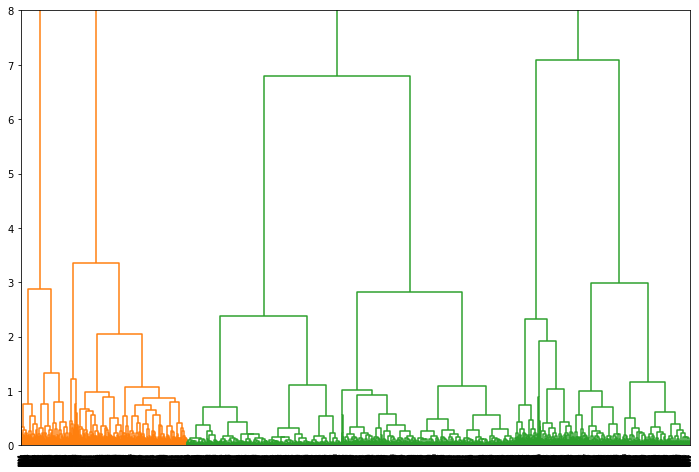

In [70]:
# Generate a dendrogram
plt.figure(figsize=(12,8))

dendrogram(mergings,
          leaf_rotation=90,
          leaf_font_size=5)
plt.ylim(0,8)
plt.show()

In [80]:
# Generate cluster labels with sklearn.cluster's AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4,
                                 affinity='euclidean',
                                 linkage='ward')
labels = cluster.fit_predict(normal_df)

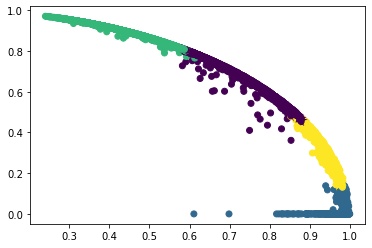

In [81]:
# Create a scatter plot with two of the features
plt.scatter(normal_df['Age'], normal_df['AbsentHours'], c=labels)
plt.show()